In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## EDA

**Seeds Dataset**
1. area A,
2. perimeter P,
3. compactness $C = \frac{4*\pi*A}{P^2}$,
4. length of kernel,
5. width of kernel,
6. asymmetry coefficient
7. length of kernel groove.

In [2]:
#import dataset
df = pd.read_csv('seeds.csv', header= None)

#name columns
df.columns = ['area','perimeter','compactness','length','width','asymmetry','groove','group']

#saving group id variable for later
groups = df['group']
df.drop('group', axis = 1, inplace = True)

df.head()

,area,perimeter,compactness,length,width,asymmetry,groove
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175


**Clean Data**

In [3]:
#check data types
df.dtypes

area           float64
perimeter      float64
compactness    float64
length         float64
width          float64
asymmetry      float64
groove         float64
dtype: object

In [4]:
#drop nan or blanks if any
df.isnull().values.any()

False

In [5]:
#mean, sd, n, 
mean = np.mean(df,axis = 0)
sd = np.std(df,axis = 0)

print('n =',df.shape[0])
df.describe().T.drop(['count'],axis = 1) #not sure which ones to drop

n = 210


,mean,std,min,25%,50%,75%,max
area,14.847524,2.909699,10.5900,12.27000,14.35500,17.305000,21.1800
perimeter,14.559286,1.305959,12.4100,13.45000,14.32000,15.715000,17.2500
compactness,0.870999,0.023629,0.8081,0.85690,0.87345,0.887775,0.9183
length,5.628533,0.443063,4.8990,5.26225,5.52350,5.979750,6.6750
width,3.258605,0.377714,2.6300,2.94400,3.23700,3.561750,4.0330
asymmetry,3.700201,1.503557,0.7651,2.56150,3.59900,4.768750,8.4560
groove,5.408071,0.491480,4.5190,5.04500,5.22300,5.877000,6.5500


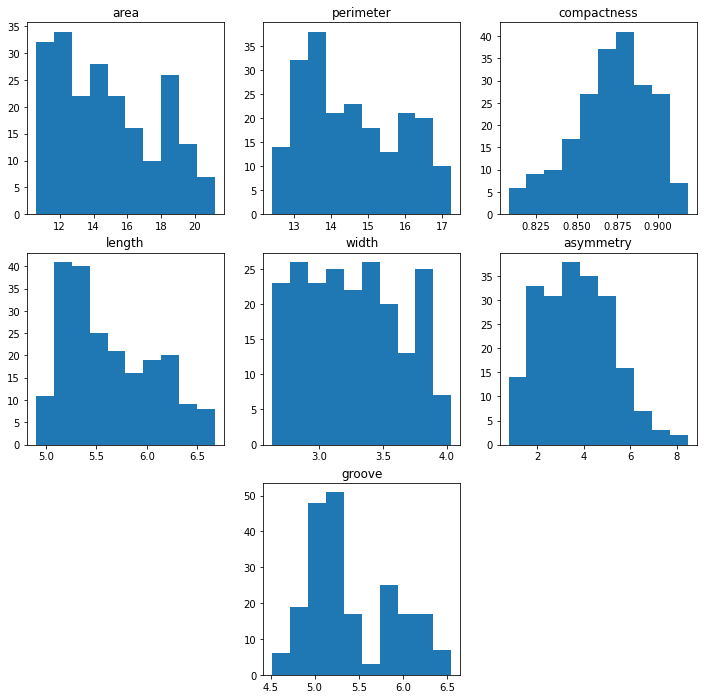

In [6]:
plt.rcParams['figure.figsize'] = [12,12] #sets figure size
fig, axs = plt.subplots(3, 3)
index = 0
#loop through number of subplots
for i in range(2):
  for j in range(3):
    axs[i,j].hist(df.iloc[:,index])
    axs[i,j].set_title(df.columns[index])
    index += 1
axs[2,1].hist(df.iloc[:,6])
axs[2,1].set_title(df.columns[6])

fig.delaxes(ax= axs[2,0]) 
fig.delaxes(ax= axs[2,2]) 

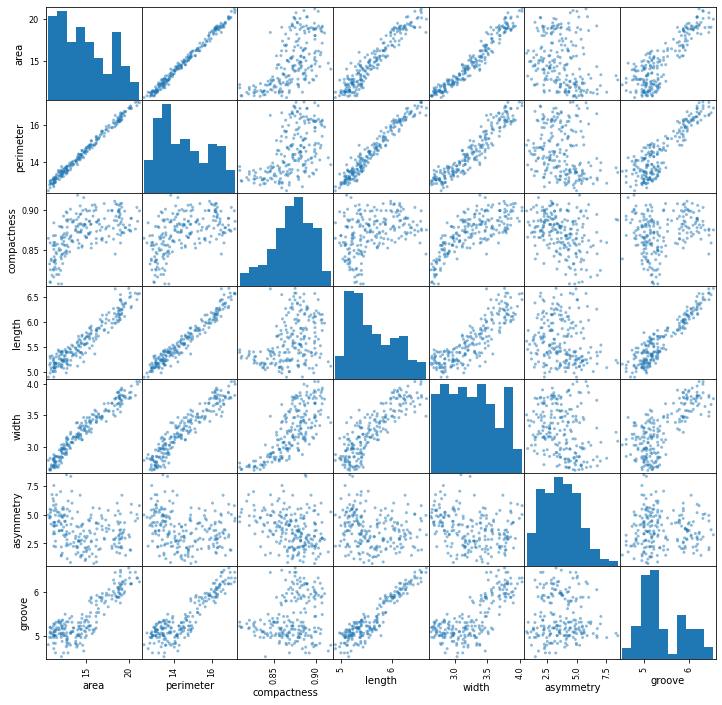

In [7]:
#scatter matrix
pd.plotting.scatter_matrix(df)
plt.show()

## PCA

In [8]:
def PCA(X, num_components):

  #Calculate the matrix of mean subtracted data points
  Z = X - np.mean(X, axis = 0)

  #Calculate the covariance matrix of the mean subtracted data points
  cov = np.cov(Z, rowvar = False)

  #Find the eigenvalues and eigenvectors of the covariance matrix
  eigen_values, eigen_vectors = np.linalg.eigh(cov)

  #Sort the eigenvalues and eigenvectors in descending order
  sorted_index = np.argsort(eigen_values)[::-1]
  sorted_eigenvalues = eigen_values[sorted_index]
  sorted_eigenvectors = eigen_vectors[:, sorted_index]

  #Create a subset from the ordered Eigenvalue matrix using the first n_components eigenvectors
  new_eigenvectors = sorted_eigenvectors[:, 0 : num_components]

  #Transform the data from higher dimension to lower dimension
  X_reduced = np.dot(new_eigenvectors.transpose(), Z.transpose()).transpose()

  return X_reduced, sorted_eigenvalues

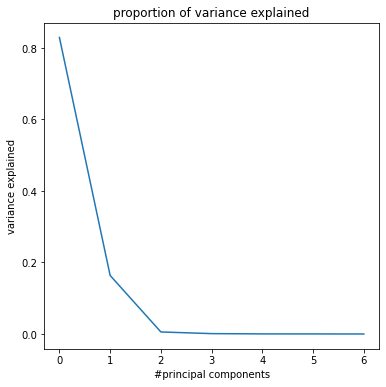

In [9]:
# Find percentage of variance explained by principal component
vals = PCA(df,7)[1] #7 doesnt matter here since we only want the eigenvalues
var_explained = vals/np.sum(vals) #standardize eigenvalues

#plot
plt.rcParams['figure.figsize'] = [6,6]
plt.plot(var_explained)
plt.title('proportion of variance explained')
plt.xlabel('#principal components')
plt.ylabel('variance explained')
plt.show()

#looks at the elbow is at 2 principal components

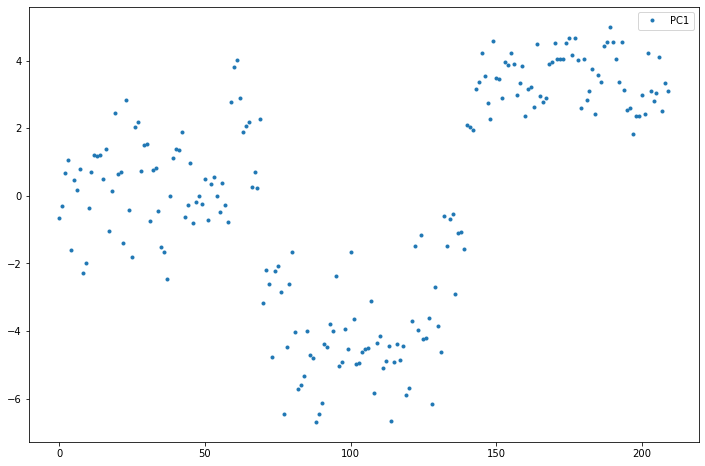

In [10]:
#Plotting the first principal component
mat_reduced = PCA(df, 1)[0]
principal_df = pd.DataFrame(mat_reduced, columns = ['PC1'])

plt.figure(figsize = (12, 8))
plt.plot(principal_df, '.', label = 'PC1')
plt.legend()

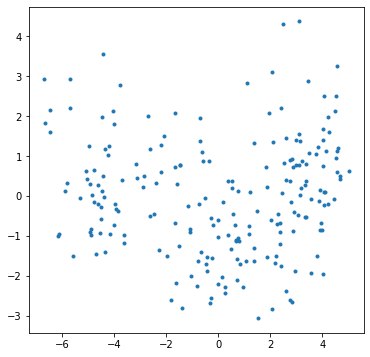

In [11]:
#Plotting the first two principal components
mat_reduced = PCA(df, 2)[0]
principal_df = pd.DataFrame(mat_reduced, columns = ['PC1', 'PC2'])
principal_matrix = principal_df.to_numpy()

# plt.figure(figsize = (12, 8))

# plt.plot(principal_matrix[:,0], '.', label = 'PC1')
# plt.plot(principal_matrix[:,1], '.', label = 'PC2')
# plt.legend()

#my attempt at the scatterplot

plt.plot(principal_matrix[:,0], principal_matrix[:,1], '.')


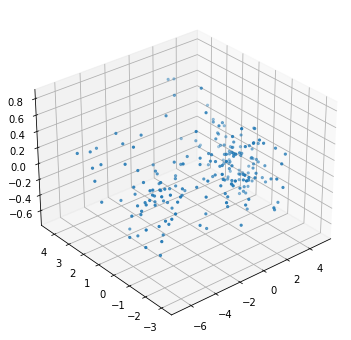

In [12]:
#Plotting the first three principal components
mat_reduced = PCA(df, 3)[0]
principal_df = pd.DataFrame(mat_reduced, columns = ['PC1', 'PC2', 'PC3'])
principal_matrix = principal_df.to_numpy()

# plt.figure(figsize = (12, 8))
# plt.plot(principal_matrix[:,0], '.', label = 'PC1')
# plt.plot(principal_matrix[:,1], '.', label = 'PC2')
# plt.plot(principal_matrix[:,2], '.', label = 'PC3')
# plt.legend()


#my attempt at a 3dplot. might have to play 
#around with the perspective with (view_init()) try (30,230), or (30,95)

X = PCA(df,3)[0]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

pc1 = X[:,0]
pc2 = X[:,1]
pc3 = X[:,2]
ax.scatter3D(pc1, pc2, pc3, marker='.')
ax.view_init(30, 230)

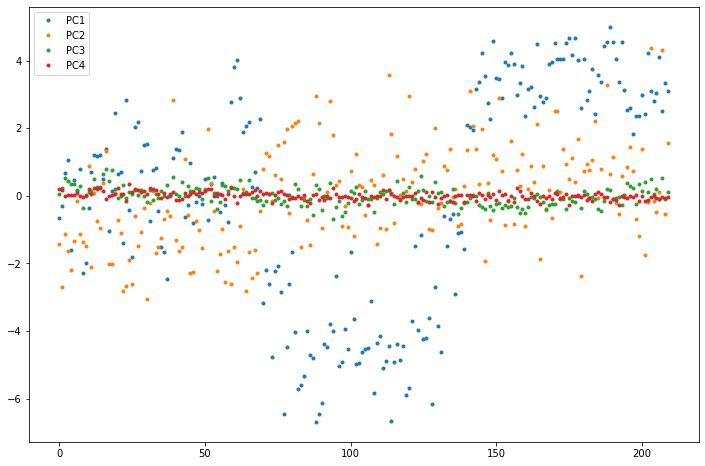

In [13]:
#Plotting the first four principal components
mat_reduced = PCA(df, 4)[0]
principal_df = pd.DataFrame(mat_reduced, columns = ['PC1', 'PC2', 'PC3', 'PC4'])
principal_matrix = principal_df.to_numpy()

plt.figure(figsize = (12, 8))
plt.plot(principal_matrix[:,0], '.', label = 'PC1')
plt.plot(principal_matrix[:,1], '.', label = 'PC2')
plt.plot(principal_matrix[:,2], '.', label = 'PC3')
plt.plot(principal_matrix[:,3], '.', label = 'PC4')
plt.legend()

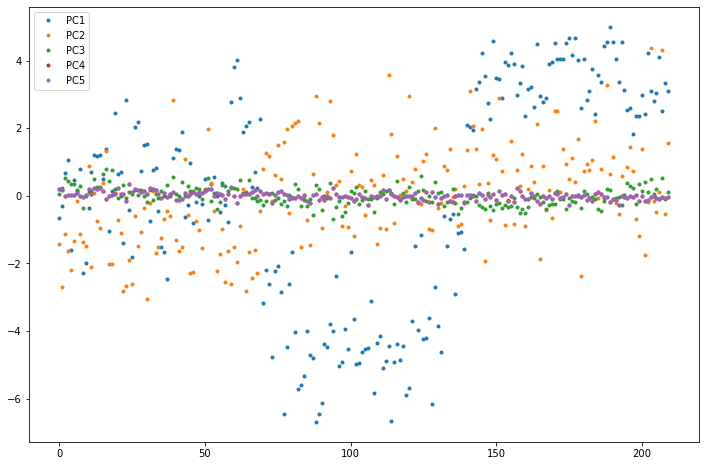

In [14]:
#Plotting the first five principal components
mat_reduced = PCA(df, 5)[0]
principal_df = pd.DataFrame(mat_reduced, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
principal_matrix = principal_df.to_numpy()

plt.figure(figsize = (12, 8))
plt.plot(principal_matrix[:,0], '.', label = 'PC1')
plt.plot(principal_matrix[:,1], '.', label = 'PC2')
plt.plot(principal_matrix[:,2], '.', label = 'PC3')
plt.plot(principal_matrix[:,3], '.', label = 'PC4')
plt.plot(principal_matrix[:,3], '.', label = 'PC5')
plt.legend()

Will probabily run kmeans and mog with 2 or 3 principal components